<a href="https://colab.research.google.com/github/HIMOTHYLMENT/project/blob/main/Another_copy_of_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Welcome to the RadixTrie hackathon**

This hackathon takes place in the field of time series anomaly detection - in other words, your goal is to identify unusual patterns or values in time-ordered data. Although this field is used in many domains such as finance, predictive maintenance, and healthcare, RadixTrie employs time series anomaly detection to monitor the health of thousands of databases automatically and alert experts if issues were identified.

First, the data is loaded. There shouldn't be a need to change the codeblock below. Two lists are created - one corresponding to train files, and the other corresponding to test files (loaded in DataFrame format).

The data is synthetic. Normal data is generated using various differential equations used to model chaotic systems - so the time series is deterministic, but difficult to predict. These "normal time series" are injected with different types of anomalies in order to create the test data.

In [ ]:
import gdown
import os

# The ID from your Google Drive URL
file_id = '1r7FLpOvDWpOWMf84PsiZ5EXy4noP3IkU'
output_zip = 'radixtrie_data.zip'

# Download the file using its ID
gdown.download(id=file_id, output=output_zip, quiet=False)

# Unzip the file to the current directory
!unzip -q -o {output_zip}

# Clean up the zip file (optional)
os.remove(output_zip)

print("File downloaded and extracted to the current directory.")

Downloading...
From: https://drive.google.com/uc?id=1r7FLpOvDWpOWMf84PsiZ5EXy4noP3IkU
To: /content/radixtrie_data.zip
100%|██████████| 18.3M/18.3M [00:00<00:00, 56.2MB/s]


File downloaded and extracted to the current directory.


In [ ]:
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt

train_file_names = os.listdir("train/")
train_file_names.sort()

train_files = []
for file in train_file_names:
    train_files.append(pd.read_csv(f"train/{file}", sep=";"))

test_file_names = os.listdir("test/")
test_file_names.sort()

test_files = []
for file in test_file_names:
    test_files.append(pd.read_csv(f"test/{file}", sep=";"))

test_files[0].head()

,Value1,Labels
0,0.028082,0.0
1,0.097887,0.0
2,0.227179,0.0
3,0.422962,0.0
4,0.673239,0.0


In each test dataframe, there are two columns. The first column, "Value1" contains the actual time series values, while "Labels" shows whether it is an anomaly or not (0 is normal and 1 is anomalous). The training set contains anomaly-free data which can be used to train a model on what "normal" behaviour is. An example from the test set is plotted below. Since time series data is a visual domain, we highly recommend plotting more of the anomaly detection problems to get a feel for the data.

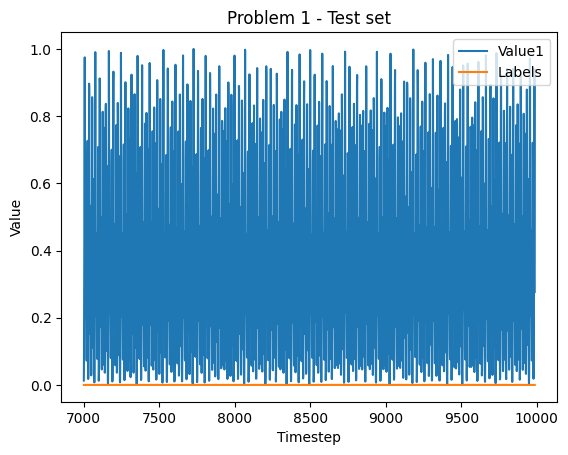

In [ ]:
test_files[0][7000:].plot()
plt.title("Problem 1 - Test set")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.show()

Take note of how the anomaly is still within the normal time series "range", but the pattern changed. Many of the anomalies are similarly subtle - they often cannot be identified only by searching for large spikes, but using machine learning to identify subtle changes in pattern. Make sure that your model takes temporal information into account (by considering the "neighbourhood" of each point). Check out the topic of windowing (in other words, using subsequences) - have a look here for a reference https://sia-ai.medium.com/anomaly-detection-in-time-series-3f36c7b4cd73.

Feel free to explore the rest of the time series as well. Plotting the data is a good way to get a feel for this kind of machine learning problem.

Define your anomaly detection class below. It follows an sklearn-style "fit predict" interface.

The fit method is used to train the model on training data. Not all anomaly detection models need to be trained, but this is provided for consistency.

The predict method executes and predicts the most anomalous timestep on the test data. For the purposes of evaluation and this hackathon, only 1 timestep is returned.

This is the only code you have to change for the purpose of this hackathon, but you are welcome to play around otherwise of course. Each model is only allowed to output one integer, corresponding to the most anomalous index.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import pandas as pd


class AnomalyDetectionModel():
    def __init__(self, window_size=10, n_neighbors=50, contamination='auto'):
        self.window_size = window_size
        # LOF is an unsupervised model, so we don't need random_state
        self.model = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=True)

    # Helper function to create windows from time series data
    def create_windows(self, X: np.ndarray):
        windows = []
        for i in range(len(X) - self.window_size + 1):
            windows.append(X[i : i + self.window_size])
        return np.array(windows)

    # Fits the model to training data (X as input, y as labels)
    def fit(self, X: np.ndarray, y: np.ndarray = None):
        # Create windows from the training data
        X_windows = self.create_windows(X)
        # Fit the LOF model on the windows
        self.model.fit(X_windows)

    # Predicts/returns the most anomalous index
    def predict(self, X: np.ndarray):
        # Create windows from the test data
        X_windows = self.create_windows(X)
        # Get anomaly scores (negative outlier factors) for each window
        # LOF returns negative_outlier_factor_ where lower is more anomalous
        anomaly_scores = self.model.decision_function(X_windows)

        # Find the window with the lowest anomaly score (most anomalous)
        most_anomalous_window_index = np.argmin(anomaly_scores)
        # Return the index of the last element in that window
        most_anomalous_index = most_anomalous_window_index + self.window_size - 1

        return most_anomalous_index

We implemented a differencing model above as a baseline. In other words, the timestep with the biggest difference with the previous timestep is flagged. Of course, better models will do better!

Check out the sklearn documentation for some examples of possible machine learning models, such as isolation forest, one-class SVMs, local outlier factor, and more. You are welcome to try deep learning models as well, but in many cases they are overkill for univariate time series data. Consider using ensembles as well to combine the predictions of multiple models. Good luck!

Below is the test script for evaluating your model on the entire dataset. There should be no need to modify this cell. If the predicted index corresponds to a true anomaly, then that test problem is marked as correct. Your total score is returned as a percentage of problems that were solved correctly.

In [ ]:
correct = 0
for train, test in zip(train_files, test_files):
    model = AnomalyDetectionModel(window_size=10, n_neighbors=50)

    model.fit(train.Value1.to_numpy().flatten(), train.Value1.to_numpy().flatten())

    prediction_index = model.predict(test.Value1.to_numpy().flatten())

    if (test.loc[prediction_index, "Labels"] == 1):
        correct += 1

print(f"Total score: {correct}%")

Total score: 64%


# Task
Optimize the hyperparameters of the `AnomalyDetectionModel` using `LocalOutlierFactor` to achieve a total score closer to 100%.

## Define hyperparameter grid

### Subtask:
Specify a range of values to explore for `window_size` and `n_neighbors`.


**Reasoning**:
Define the parameter grid for hyperparameter tuning.



In [ ]:
param_grid = {
    'window_size': [5, 10, 15, 20],
    'n_neighbors': [10, 20, 30, 50]
}

## Iterate and evaluate

### Subtask:
Loop through each combination of hyperparameters, train the `AnomalyDetectionModel` with those parameters, and evaluate its performance using the existing evaluation script.


**Reasoning**:
Initialize variables for best score and hyperparameters and then iterate through the hyperparameter grid, train the model, evaluate, and update the best parameters if a better score is found.



In [ ]:
best_score = 0
best_params = {}

for window_size in param_grid['window_size']:
    for n_neighbors in param_grid['n_neighbors']:
        correct = 0
        for train, test in zip(train_files, test_files):
            model = AnomalyDetectionModel(window_size=window_size, n_neighbors=n_neighbors, contamination='auto')
            model.fit(train.Value1.to_numpy().flatten())
            prediction_index = model.predict(test.Value1.to_numpy().flatten())

            if (test.loc[prediction_index, "Labels"] == 1):
                correct += 1

        current_score = correct
        print(f"Hyperparameters: window_size={window_size}, n_neighbors={n_neighbors}, Score: {current_score}")

        if current_score > best_score:
            best_score = current_score
            best_params = {'window_size': window_size, 'n_neighbors': n_neighbors}

print(f"\nBest Score: {best_score}")
print(f"Best Hyperparameters: {best_params}")

Hyperparameters: window_size=5, n_neighbors=10, Score: 68
